# Imports

In [1]:
import os
from datetime import datetime

import geopandas as gpd
import movingpandas as mpd
import torch
from shapely.geometry import Point
from srai.datasets import PortoTaxiDataset
from srai.embedders import Hex2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods import H3Neighbourhood
from srai.regionalizers import H3Regionalizer
from tqdm import tqdm

In [2]:
gpd.options.io_engine = "pyogrio"

# Enable loading Environment Variables

In [3]:
%load_ext dotenv

%dotenv

In [4]:
hf_token = os.getenv("HF_TOKEN")

# Data Loading

In [5]:
subset_size = 1_000
use_subset = True

gdf_porto_taxi_full_path = "porto_taxi.feather"
gdf_porto_taxi_subset_path = f"porto_taxi_subset_{subset_size}.feather"

In [6]:
if not use_subset:
    if not os.path.exists(gdf_porto_taxi_full_path):
        porto_taxi_dataset = PortoTaxiDataset()
        gdf_porto_taxi = porto_taxi_dataset.load(hf_token=hf_token)
        gdf_porto_taxi.to_feather(gdf_porto_taxi_full_path)
    else:
        gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_full_path)
else:
    if not os.path.exists(gdf_porto_taxi_subset_path):
        if not os.path.exists(gdf_porto_taxi_full_path):
            porto_taxi_dataset = PortoTaxiDataset()
            gdf_porto_taxi = porto_taxi_dataset.load(hf_token=hf_token)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_full_path)
            gdf_porto_taxi = gdf_porto_taxi.head(subset_size)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_subset_path)
        else:
            gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_full_path)
            gdf_porto_taxi = gdf_porto_taxi.head(subset_size)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_subset_path)
    else:
        gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_subset_path)

In [7]:
gdf_porto_taxi.drop(
    [
        "taxi_id",
        "call_type",
        "origin_call",
        "origin_stand",
        "day_type",
        "travel_time_seconds",
    ],
    axis=1,
    inplace=True,
)

# Convert LineString to Point

In [8]:
exploded_rows = []

for idx, row in tqdm(gdf_porto_taxi.iterrows(), total=gdf_porto_taxi.shape[0]):
    start_timestamp = row.timestamp
    current_timestamp = start_timestamp
    for xy in row.geometry.coords:
        point = Point(xy)
        row_dict = row.to_dict()
        row_dict["geometry"] = point
        row_dict["timestamp"] = current_timestamp
        current_timestamp += 15
        exploded_rows.append(row_dict)

100%|██████████| 1000/1000 [00:00<00:00, 2234.07it/s]


In [9]:
gdf_porto_taxi_points = gpd.GeoDataFrame(exploded_rows, crs="EPSG:4326")

In [10]:
gdf_porto_taxi_points["timestamp"] = gdf_porto_taxi_points["timestamp"].apply(
    lambda x: datetime.fromtimestamp(x)
)

In [11]:
gdf_porto_taxi_points.head()

,trip_id,timestamp,geometry
0,1372636858620000589,2013-07-01 02:00:58,POINT (-8.61864 41.14141)
1,1372636858620000589,2013-07-01 02:01:13,POINT (-8.61850 41.14138)
2,1372636858620000589,2013-07-01 02:01:28,POINT (-8.62033 41.14251)
3,1372636858620000589,2013-07-01 02:01:43,POINT (-8.62215 41.14381)
4,1372636858620000589,2013-07-01 02:01:58,POINT (-8.62395 41.14437)


# Trajectory Collection

In [12]:
trajectory_collection = mpd.TrajectoryCollection(
    data=gdf_porto_taxi_points, traj_id_col="trip_id", t="timestamp"
)

In [13]:
# filtered_trajectories = [
#     traj for traj in trajectory_collection if traj.get_length() <= 15000
# ]
# 
# filtered_trajectory_collection = mpd.TrajectoryCollection(filtered_trajectories)

<Axes: >

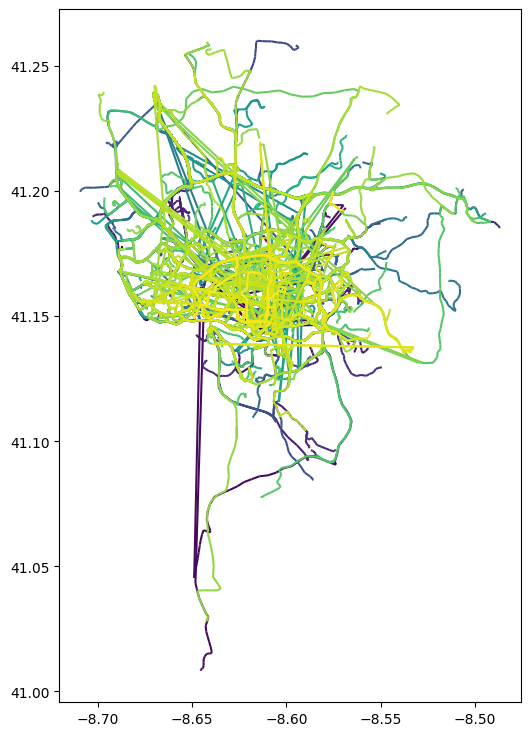

In [14]:
trajectory_collection.plot(column="trip_id", legend=False, figsize=(16, 9))

In [15]:
# trajectory_collection.hvplot()

In [16]:
# trajectory_collection.add_speed(overwrite=True).add_acceleration(
#     overwrite=True
# ).add_distance(overwrite=True).add_direction(overwrite=True).add_timedelta(
#     overwrite=True
# ).add_angular_difference(
#     overwrite=True
# ).add_traj_id(
#     overwrite=True
# ).to_traj_gdf()

In [17]:
single_trajectory = trajectory_collection.trajectories[1]

In [18]:
single_trajectory.to_traj_gdf()

,trip_id,start_t,end_t,geometry,length,direction
0,1372636854620000520,2013-07-01 02:00:54,2013-07-01 02:11:24,"LINESTRING (-8.57468 41.15195, -8.57470 41.151...",7983.147969,250.204142


In [19]:
single_trajectory.hvplot(c="speed")

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

# Regionalizer

In [39]:
regionalizer = H3Regionalizer(resolution=9)
regions = regionalizer.transform(gdf_porto_taxi_points)

<Axes: >

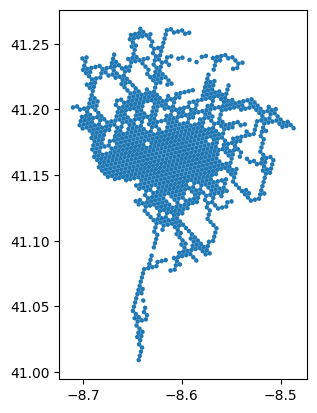

In [41]:
regions.plot()

# Features from regions

In [42]:
loader = OSMPbfLoader()
features = loader.load(regions, HEX2VEC_FILTER)

C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\srai\loaders\osm_loaders\osm_pbf_loader.py:128: FutureWarning: Use `convert_geometry_to_geodataframe` instead. Deprecated since 0.8.1 version.
  features_gdf = pbf_reader.get_features_gdf_from_geometry(
C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
100%|########################################| 333M/333M [00:00<00:00, 333GB/s]
SHA256 hash of downloaded file: 33f31bcb64aa900c584a67d1827dff8d3cfcf2205766a9a965919ec0b23e121c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Output()

Finished operation in 0:02:11

In [43]:
features.head()

,geometry,aeroway,amenity,building,healthcare,historic,landuse,leisure,military,natural,office,shop,sport,tourism,water,waterway
feature_id,,,,,,,,,,,,,,,,
node/4703675433,POINT (-8.59034 41.18329),None,fountain,None,None,None,None,None,None,None,None,None,None,None,None,None
node/4703883573,POINT (-8.65230 41.17747),None,None,None,None,None,None,None,None,None,None,tyres,None,None,None,None
node/4703883574,POINT (-8.65191 41.17715),None,None,None,None,None,None,None,None,None,None,paint,None,None,None,None
node/4703883575,POINT (-8.65131 41.17665),None,None,None,None,None,None,None,None,None,yes,None,None,None,None,None
node/4703883576,POINT (-8.64995 41.17507),None,None,None,None,None,None,None,None,None,None,car,None,None,None,None


# Join Regions with Features

In [44]:
joiner = IntersectionJoiner()
joint = joiner.transform(regions, features)

In [45]:
neighbourhood = H3Neighbourhood(regions)

In [46]:
embedder_hidden_sizes = [150, 100, 50, 10]
embedder = Hex2VecEmbedder(embedder_hidden_sizes)

# Fit Embeddings

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embeddings = embedder.fit_transform(
    regions,
    features,
    joint,
    neighbourhood,
    trainer_kwargs={"max_epochs": 15, "accelerator": device},
    batch_size=100,
)

100%|██████████| 1183/1183 [00:00<00:00, 27176.37it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080') tha

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [48]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9
region_id,,,,,,,,,,
8939220e11bffff,-0.318000,0.053943,0.451359,0.409700,-0.303867,0.228278,0.025094,-0.127653,0.641587,0.670966
8939220e31bffff,1.028923,-0.594267,0.892847,0.809194,-0.256666,0.152347,0.920750,0.133057,0.054980,0.246130
8939220f613ffff,0.742692,-0.458153,0.488627,0.644118,-0.215895,-0.144649,0.511037,-0.158778,-0.745960,0.538462
8939220ad67ffff,0.819814,0.134566,0.161473,-0.358453,-0.647480,-0.638102,-0.595354,-0.213780,-1.182413,-1.151304
8939220c61bffff,0.232570,-0.151660,0.947090,0.009534,-0.595862,-0.089190,0.371231,0.377406,0.606257,-0.471742
